# Programming Assignment #4: Recurrent Neural Networks
Author: Pierre Nugues

## Objectives

The objectives of this assignment are to:
* Write a program to recognize named entities in text
* Learn how to manage a text data set
* Apply recurrent neural networks to text
* Know what word embeddings are
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization and location

You can work alone or collaborate with another student:
* Each group will have to write Python programs to recognize named entities in text.
* You will have to experiment different architectures, namely RNN and LSTM, and compare the results you obtained.
* Each student will have to write an individual report on these experiments.

## Imports

In [1]:
import sys
import regex as re
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.activations import softmax
from keras.optimizers import RMSprop, Adam # iterative improvements

EPOCHS = 15
LSTM_UNITS = 100

## Collecting a Dataset

1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). In this assignment, you will work on the English dataset. Read the description of the task.
2. The datasets are protected by a license and you need to obtain it to reconstruct the data. Alternatively, you can try to find one on github (type conll2003 in the search box) or use the Google dataset search: <a href="https://toolbox.google.com/datasetsearch">https://toolbox.google.com/datasetsearch</a>. All this may take time and your teacher created a local copy in the `/usr/local/cs/EDAN95/datasets/NER-data` folder.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

## Reading the Corpus

You will read the corpus with the cells below. The functions will enable you to load the files in the form of a list of dictionaries.

In [2]:
BASE_DIR = '/kaggle/input/conll2003-eng/'

In [3]:
def load_conll2003_en():
    train_file = BASE_DIR + 'eng.train'
    dev_file = BASE_DIR + 'eng.valid'
    test_file = BASE_DIR + 'eng.test'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [4]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- O O\n\nEU NNP I-NP I-ORG\nrejects VBZ I-VP O\nGerman JJ I-NP I-MISC\ncall NN I-NP O\nto TO '

In [5]:
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [6]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [7]:
print(train_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': 'O', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating your Models

You will train the models with the traiing set and the test set to evaluate them. For this, you will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl and you have a local copy of this script in `/usr/local/cs/EDAN95/datasets/ner/bin`. Some people rewrote it in Python and you will use such such a translation in this lab. The line below installs it.

In [8]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

You will represent the words with the GloVe embeddings:
1. Download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. You have a local copy of this script in `/usr/local/cs/EDAN95/datasets/`;
3. Apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [9]:
embedding_file = '/kaggle/input/glove6b/glove.6B.100d.txt'

In [10]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [11]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 5 closest words to the words _table_, _france_, and _sweden_

In [12]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(arr1, arr2):
    return dot(arr1, arr2)/(norm(arr1)*norm(arr2))


def closest(target_word, embeddings, count=10):
    embedded_words = sorted(list(embeddings.keys()))
    closest_words = []
    closest_cos_sim = []
    if target_word in embeddings:
        for word in embeddings:
            cos_sim = cosine_similarity(embeddings[target_word], embeddings[word])
            if len(closest_words) >= count:
                if cos_sim > min(closest_cos_sim):
                    replace_ind = closest_cos_sim.index(min(closest_cos_sim))
                    closest_words[replace_ind] = word
                    closest_cos_sim[replace_ind] = cos_sim
            else:
                closest_words.append(word)
                closest_cos_sim.append(cos_sim)
        
    return closest_words

In [13]:
closest('france', embeddings_dict)

['france',
 'britain',
 'germany',
 'spain',
 'europe',
 'italy',
 'belgium',
 'paris',
 'netherlands',
 'french']

In [14]:
closest('table', embeddings_dict)

['here',
 'room',
 'top',
 'tables',
 'sit',
 'table',
 'place',
 'pool',
 'side',
 'bottom']

In [15]:
closest('sweden', embeddings_dict)

['germany',
 'denmark',
 'finland',
 'sweden',
 'belgium',
 'switzerland',
 'swedish',
 'netherlands',
 'norway',
 'austria']

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [16]:
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    x = []
    y = []
    for sentence in corpus_dict:
        x_sent = []
        y_sent = []
        for word in sentence:
            if tolower == True: x_sent.append(word[key_x].lower())
            else: x_sent.append(word[key_x])
            y_sent.append(word[key_y])
        x.append(x_sent)
        y.append(y_sent)
        
    return x, y

Apply this function to your datasets so that you create $\mathbf{X}$ and $\mathbf{Y}$ lists of lists consisting of words and NER tags
        
For the second sentence of the training set, you should have:<br/>
<tt>x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']</tt><br/>
<tt>y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']</tt><br/>
Some datasets you may find on the web use a different NER tagset, where <tt>I-</tt> is
replaced with <tt>B-</tt>, like <tt>B-ORG</tt> instead of <tt>I-ORG</tt>. This will not change the results.

In [17]:
X, Y = build_sequences(train_dict, key_x='form', key_y='ner')
print('First sentence, words', X[1])
print('First sentence, NER', Y[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words from the CoNLL training set and the list of tags. You will sort them

In [18]:
words = sorted(set([word for sentence in X for word in sentence]))
ner = sorted(set([tag for sentence in Y for tag in sentence]))

In [19]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(ner))

# words seen in training corpus: 21010
# NER tags seen: 8


Then merge the list of unique CoNLL words with the words in the embedding file. You will sort this list

In [20]:
vocabulary_words = sorted(set(embedded_words + list(words)))

In [21]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [22]:
ner

['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [23]:
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner, start=2))
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}

In [24]:
print('word index:', list(word2idx.items())[:25])
print('NER index:', list(ner2idx.items())[:25])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]
NER index: [('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('I-LOC', 5), ('I-MISC', 6), ('I-ORG', 7), ('I-PER', 8), ('O', 9)]


## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [25]:
import numpy as np
embedding_matrix = np.random.rand(len(word2idx) + 2, 100)

In [26]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [27]:
out_of_embeddings = []
for word_ind in range(2, embedding_matrix.shape[0]):
    word = idx2word[word_ind]
    if word in embeddings_dict:
        embedding_matrix[word_ind][:] = embeddings_dict[word]
    else: out_of_embeddings.append(word)

In [28]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [29]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [0.99700539 0.05560402 0.82106214 0.01471551 0.80582535 0.37538395
 0.30269603 0.52270705 0.4153805  0.27994419]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [0.27323288 0.81227616 0.56051536 0.23630281 0.65771501 0.72034957
 0.32045    0.6684907  0.09311806 0.26891462]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices you created

In [30]:
Y[:3]

[['O'],
 ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O'],
 ['I-PER', 'I-PER']]

In [31]:
X_idx = []
for sentence in X:
    X_sent_idx = []
    for word in sentence:
        if word in word2idx:
            X_sent_idx.append(word2idx[word])
        else: X_dev_sent_idx.append(1)
    X_idx.append(X_sent_idx)
    
Y_idx = []
for sentence in Y:
    Y_sent_idx = []
    for tag in sentence:
        if tag in ner2idx:
            Y_sent_idx.append(ner2idx[tag])
        else: print(tag)
    Y_idx.append(Y_sent_idx)

In [32]:
print('First sentences, word indices', X_idx[:3])
print('First sentences, POS indices', Y_idx[:3])

First sentences, word indices [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
First sentences, POS indices [[9], [7, 9, 6, 9, 9, 9, 6, 9, 9], [8, 8]]


Pad the sentences using the <tt>pad_sequences</tt> function. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [     0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0 142143 307143 161836  91321 363368  83766  85852 218260    936]
y = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 9 6 9 9 9 6
9 9]
```

In [33]:
X = pad_sequences(X_idx, maxlen=150)
Y = pad_sequences(Y_idx, maxlen=150)

In [34]:
print(X[1])
print(Y[1])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [35]:
y_train = to_categorical(Y, num_classes=len(ner) + 2)

In [36]:
y_train[1][-10:]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Do the same for the development set: Build the sequences, map them to indices, pad them, and create $\mathbf{Y}$ vectors

In [37]:
# Build sequences
X_dev, Y_dev = build_sequences(dev_dict, key_x='form', key_y='ner')

# Map to indices
X_dev_idx = []
for sentence in X_dev:
    X_dev_sent_idx = []
    for word in sentence:
        # Indices > 2
        if word in word2idx:
            X_dev_sent_idx.append(word2idx[word])
        # If word is unknown, it gets index 1
        else: X_dev_sent_idx.append(1)
    X_dev_idx.append(X_dev_sent_idx)
    
Y_dev_idx = []
for sentence in Y_dev:
    Y_dev_sent_idx = []
    for tag in sentence:
        if tag in ner2idx:
            Y_dev_sent_idx.append(ner2idx[tag])
        else:
            print(tag)
    Y_dev_idx.append(Y_dev_sent_idx)

# Pad index mappings
X_dev = pad_sequences(X_dev_idx, maxlen=150)
Y_dev = pad_sequences(Y_dev_idx, maxlen=150)

y_dev = to_categorical(Y_dev, num_classes=len(ner) + 2)

## Building a Simple Recurrent Neural Network

Create a simple recurrent network and train a model with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`.

In [38]:
dim = embedding_matrix.shape[1]
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], dim, mask_zero=True, input_length=None))
model.add(SimpleRNN(dim, return_sequences=True))
model.add(SimpleRNN(dim, return_sequences=True))
model.add(SimpleRNN(dim, return_sequences=True))
model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(len(ner) + 2, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         40259700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         20100     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
dense (Dense)                (None, None, 10)          2

Compile your network. 

In [39]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['acc'])

Fit it

In [40]:
history = model.fit(np.asarray(X), y_train,
                    epochs=EPOCHS,
                    batch_size=32,
                    validation_data=(np.asarray(X_dev), y_dev))

Epoch 1/15
469/469 [==============================] - 761s 2s/step - loss: 0.0240 - acc: 0.9219 - val_loss: 0.0150 - val_acc: 0.9544
Epoch 2/15
469/469 [==============================] - 771s 2s/step - loss: 0.0114 - acc: 0.9612 - val_loss: 0.0141 - val_acc: 0.9578
Epoch 3/15
469/469 [==============================] - 785s 2s/step - loss: 0.0083 - acc: 0.9719 - val_loss: 0.0115 - val_acc: 0.9675
Epoch 4/15
469/469 [==============================] - 787s 2s/step - loss: 0.0064 - acc: 0.9783 - val_loss: 0.0110 - val_acc: 0.9697
Epoch 5/15
469/469 [==============================] - 790s 2s/step - loss: 0.0051 - acc: 0.9825 - val_loss: 0.0103 - val_acc: 0.9710
Epoch 6/15
469/469 [==============================] - 792s 2s/step - loss: 0.0041 - acc: 0.9861 - val_loss: 0.0106 - val_acc: 0.9703
Epoch 7/15
469/469 [==============================] - 797s 2s/step - loss: 0.0033 - acc: 0.9888 - val_loss: 0.0106 - val_acc: 0.9703
Epoch 8/15
469/469 [==============================] - 807s 2s/step - 

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

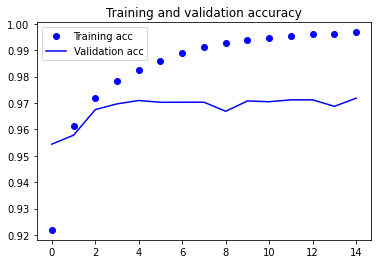

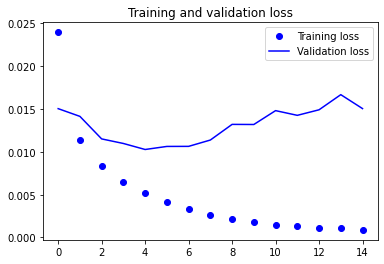

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apply your network to one sentence.

In [42]:
sentence = 'The United States might collapsez'.lower().split()

First convert the sentence into indices

In [43]:
sentence_idx = []
for token in sentence:
    if token in word2idx:
        sentence_idx.append(word2idx[token])
    else:
        sentence_idx.append(1)
sentence_idx

[359698, 374678, 344404, 246008, 1]

Apply the prediction

In [44]:
ner2idx.items()

dict_items([('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('I-LOC', 5), ('I-MISC', 6), ('I-ORG', 7), ('I-PER', 8), ('O', 9)])

In [45]:
model.predict(sentence_idx)

array([[[2.60328416e-05, 2.12968844e-05, 1.20082041e-04, 1.31457855e-04,
         4.04576567e-05, 4.42539342e-03, 2.12221360e-03, 9.33129434e-03,
         3.86257714e-04, 9.83395457e-01]],

       [[6.45087994e-06, 5.53136533e-06, 5.46405354e-05, 6.79968434e-05,
         1.05916924e-05, 9.08522308e-01, 5.46214927e-04, 9.06314179e-02,
         6.40009675e-05, 9.08633083e-05]],

       [[1.53353467e-04, 1.51743283e-04, 8.22729548e-04, 4.36063565e-04,
         1.39378346e-04, 9.50389922e-01, 2.82948185e-03, 2.83700991e-02,
         1.45990716e-03, 1.52473403e-02]],

       [[3.19360523e-03, 2.93650175e-03, 1.74542498e-02, 1.98448803e-02,
         1.00167701e-02, 1.27222762e-01, 1.26448981e-02, 3.15424167e-02,
         1.57581151e-01, 6.17562771e-01]],

       [[2.86025679e-05, 2.72951056e-05, 3.07639013e-04, 9.29140486e-04,
         1.00188328e-04, 1.17223740e-01, 1.43693998e-01, 1.06237344e-01,
         1.33801457e-02, 6.18071914e-01]]], dtype=float32)

In [46]:
y_pred = np.argmax(model.predict(sentence_idx), axis=-1)
print(y_pred)
for i, tag_ind in enumerate(y_pred):
    if tag_ind[0] in idx2ner:
        print(f'{sentence[i]}: {idx2ner[tag_ind[0]]}')
    else:
        print(f'{sentence[i]}: O')

[[9]
 [5]
 [5]
 [9]
 [9]]
the: O
united: I-LOC
states: I-LOC
might: O
collapsez: O


## Evaluating your System

You will now evaluate the performance of your system on the whole test set. You will use the official script.
<ol>
    <li>Use the <tt>predict</tt> method to predict the tags of the whole test set
    </li>
    <li>Write your results in a file, where the two last columns will be the hand-annotated tag
        and the predicted tag. The fields must be separated by a space and each line must end with a new line:
        <tt>\n</tt>.
    </li>
    <li>
        If you save your results on a Windows machine, Python will use the default end-of-line sequence: <tt>\r\n</tt>.
        You will then need either to convert your file or to modify the way you save your file.
    </li>
    <li>Apply <tt>conlleval</tt> to your output. Report the F1 result.<br/>
        Be aware that <tt>conlleval</tt> was designed for Unix and will break
    with Windows end-of-line conventions.</li>
    <li>Try to improve your model by modifying some parameters, adding layers, adding
        <tt>Bidirectional</tt>
        and <tt>Dropout</tt>.
    </li>
    <li>
        Evaluate your network again
    </li>
</ol>

First translate the input part of the test set, the words, into lists of words, `X_test`, lists of indices, `X_test_idx`, and a matrix of indices, where you will pad the sequences: `X_test_padded`

In [47]:
# Test
X_test, Y_test = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test[1])
print('Y_test', Y_test[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-PER', 'O', 'O', 'O', 'O']


In [48]:
# Map to indices
X_test_idx = []
for sentence in X_test:
    X_test_sent_idx = []
    for word in sentence:
        if word in word2idx:
            X_test_sent_idx.append(word2idx[word])
        else: X_test_sent_idx.append(1)
    X_test_idx.append(X_test_sent_idx)
    
Y_test_idx = []
for sentence in Y_test:
    Y_test_sent_idx = []
    for tag in sentence:
        Y_test_sent_idx.append(ner2idx[tag])
    Y_test_idx.append(Y_test_sent_idx)

# Pad index mappings
X_test_padded = np.asarray(pad_sequences(X_test_idx, maxlen=150))
Y_test_padded = pad_sequences(Y_test_idx, maxlen=150)

In [49]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded: [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

In [50]:
X_test_padded.shape

(3684, 150)

Now predict the whole test set with `predict` and set the results in `Y_test_hat`

In [51]:
Y_test_hat = model.predict(X_test_padded)

In [52]:
print('X_test', X_test[1])
print('X_test_padded', X_test_padded[1])
print('Predictions', Y_test_hat[0])

X_test ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
X_test_padded [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0    

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [53]:
len(Y_test_hat[0])

150

In [54]:
# Remove paddings
Y_test_probs = []
for sent_nbr, y_test_hat in enumerate(Y_test_hat):
    Y_test_probs += [y_test_hat[-len(X_test_idx[sent_nbr]):]]
Y_test_probs[1]

array([[9.39171102e-11, 8.16920628e-11, 4.46749554e-10, 1.54997759e-09,
        7.11122827e-11, 3.34778133e-06, 2.09879931e-06, 3.89779962e-05,
        1.65532967e-07, 9.99955416e-01],
       [1.87614473e-11, 1.32144348e-11, 5.33162715e-11, 2.18632765e-10,
        2.60610110e-11, 7.43481849e-07, 2.19987967e-07, 1.06328366e-06,
        2.43909231e-08, 9.99997973e-01],
       [1.81511943e-08, 1.65191913e-08, 1.85305751e-07, 4.32386599e-07,
        1.93023588e-08, 9.99271810e-01, 4.49646934e-04, 1.17156385e-04,
        1.33509438e-05, 1.47471656e-04],
       [2.56671001e-06, 2.82211317e-06, 2.89310592e-05, 1.41459444e-04,
        7.84206804e-06, 6.98869640e-04, 1.00685610e-02, 1.55875029e-03,
        2.45359982e-03, 9.85036612e-01],
       [1.81084852e-05, 2.25632757e-05, 1.03967912e-04, 9.10689880e-04,
        5.13447412e-05, 4.00749035e-03, 3.56849730e-02, 1.30535616e-02,
        7.40294337e-01, 2.05853000e-01],
       [4.72733741e-10, 3.85131121e-10, 1.81990811e-09, 1.97939247e-08,
   

In [55]:
def extract_indices(dictionary, predicted_hat):
    transform = dictionary
    for sent_ind, sentence in enumerate(predicted_hat):
        for dict_word_ind, word_probs in enumerate(sentence):
            index = np.argmax(word_probs)
            if index > 0:
                try:
                    if index == 1: transform[sent_ind][dict_word_ind]['pner'] = 'O'
                    else: transform[sent_ind][dict_word_ind]['pner'] = idx2ner[index]
                except IndexError:
                    print(sent_ind)
                    print(dict_word_ind)
    return transform

test_dict = extract_indices(test_dict, Y_test_probs)  

In [56]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-LOC',
  'pner': 'I-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'O',
  'pner': 'I-PER'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'I-NP',
  'ner': 'I-PER',
  'pner': 'I-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'I-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

In [57]:
ARCH = '1'
outfile = 'test' + ARCH + '.out'
outfile = 'RNN'

In [58]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [59]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [60]:
save(outfile, test_dict, column_names)

In [61]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
baseline_score = res['overall']['chunks']['evals']['f1']
baseline_score

0.7937096916688754

## Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use <tt>Embedding</tt>, <tt>LSTM</tt>, and <tt>Dense</tt>.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding <tt>Bidirectional</tt>, <tt>Dropout</tt>, possibly mixing <tt>SimpleRNN</tt>.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [62]:
dim = embedding_matrix.shape[1]
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], dim, mask_zero=True, input_length=None))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(len(ner) + 2, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          2010      
Total params: 40,422,510
Trainable params: 40,422,510
Non-trainable params: 0
_________________________________________________________________


Compile and fit it

In [63]:
#optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = RMSprop(lr=0.0001)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(np.asarray(X), y_train,
                    epochs=EPOCHS,
                    batch_size=32,
                    validation_data=(np.asarray(X_dev), y_dev))

Epoch 1/15
469/469 [==============================] - 513s 1s/step - loss: 0.0257 - acc: 0.9158 - val_loss: 0.0163 - val_acc: 0.9511
Epoch 2/15
469/469 [==============================] - 512s 1s/step - loss: 0.0136 - acc: 0.9541 - val_loss: 0.0114 - val_acc: 0.9661
Epoch 3/15
469/469 [==============================] - 502s 1s/step - loss: 0.0108 - acc: 0.9631 - val_loss: 0.0100 - val_acc: 0.9705
Epoch 4/15
469/469 [==============================] - 499s 1s/step - loss: 0.0093 - acc: 0.9685 - val_loss: 0.0089 - val_acc: 0.9735
Epoch 5/15
469/469 [==============================] - 500s 1s/step - loss: 0.0082 - acc: 0.9720 - val_loss: 0.0095 - val_acc: 0.9730
Epoch 6/15
469/469 [==============================] - 498s 1s/step - loss: 0.0073 - acc: 0.9750 - val_loss: 0.0083 - val_acc: 0.9759
Epoch 7/15
469/469 [==============================] - 501s 1s/step - loss: 0.0066 - acc: 0.9775 - val_loss: 0.0078 - val_acc: 0.9767
Epoch 8/15
469/469 [==============================] - 503s 1s/step - 

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

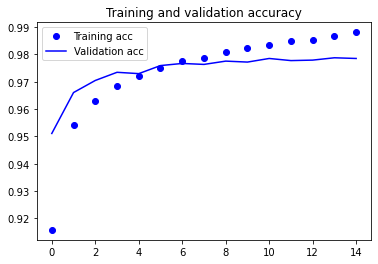

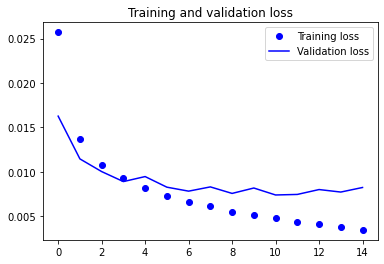

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Predict the NER sequence

In [65]:
Y_test_hat = model.predict(X_test_padded)
Y_test_probs = []
for sent_nbr, y_test_hat in enumerate(Y_test_hat):
    Y_test_probs += [y_test_hat[-len(X_test_idx[sent_nbr]):]]

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [66]:
def extract_indices(dictionary, predicted_hat):
    transform = dictionary
    for sent_ind, sentence in enumerate(predicted_hat):
        for dict_word_ind, word_probs in enumerate(sentence):
            index = np.argmax(word_probs)
            if index > 0:
                try:
                    if index == 1: transform[sent_ind][dict_word_ind]['pner'] = 'O'
                    else: transform[sent_ind][dict_word_ind]['pner'] = idx2ner[index]
                except IndexError:
                    print(sent_ind)
                    print(dict_word_ind)
    return transform

In [67]:
test_dict = conll_dict.transform(test_sentences)
test_dict = extract_indices(test_dict, Y_test_probs) # Function from previous section

In [68]:
ARCH = '4'
outfile = 'test' + ARCH + '.out'
outfile= 'LSTM3'

In [69]:
save(outfile, test_dict, column_names)

In [70]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
improved_score

0.8438083385189795

You need to reach 82 to pass the assignment.